# CSE 546: SARSA demo

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces

# Defining the Environment

In [192]:
class GridEnvironment(gym.Env):
    metadata = { 'render.modes': [] }
    
    def __init__(self, n = 3, is_stochastic = False, random_start = False):
        self.observation_space = spaces.Discrete(n ** 2)
        self.action_space = spaces.Discrete(4)
        self.max_timesteps = 3 * n + 1
        self.is_stochastic = is_stochastic
        self.n = n
        self.random_start = random_start

        # defining stochastic environment such that ∑P_i = 1
        if self.is_stochastic:
          self.transition_prob = []
          for i in range(n):
            x = []
            for j in range(n):
              y = []
              for action in range(self.action_space.n):
                z = [.1] * self.action_space.n
                z[action] = .7
                y.append(z)
              x.append(y)
            self.transition_prob.append(x)

        
    def reset(self):
        self.timestep = 0
        self.agent_pos = np.zeros(2, dtype = int)
        if self.random_start:
          self.agent_pos = np.random.randint(self.n, size = 2)
        self.goal_pos = [self.n - 1, self.n - 1]
        self.monster_pos = [self.n // 2, self.n // 2]
        self.update_state()
        observation = self.agent_pos
        return observation
    
    def update_state(self):
      self.state = np.zeros((self.n, self.n))
      self.state[tuple(self.goal_pos)] = 0.5
      self.state[tuple(self.monster_pos)] = 0.25
      self.state[tuple(self.agent_pos)] = 1

    def get_action(self, x, y, action):
      return np.random.choice(self.action_space.n, p = self.transition_prob[x][y][action])

    def step(self, action):
        if self.is_stochastic:
          action = self.get_action(self.agent_pos[0], self.agent_pos[1], action)

        # top-left: (0, 0)
        if action == 0: #down
          self.agent_pos[0] += 1
        if action == 1: #up
          self.agent_pos[0] -= 1
        if action == 2: #right
          self.agent_pos[1] += 1
        if action == 3: #left
          self.agent_pos[1] -= 1
          
        self.agent_pos = np.clip(self.agent_pos, 0, self.n - 1)
        self.update_state()
        observation = self.agent_pos
        
        reward = 0
        goal_reached = (self.agent_pos == self.goal_pos).all()
        if goal_reached:
          reward = 10

        found_monster = (self.agent_pos == self.monster_pos).all()
        if found_monster:
          reward = -10
        
        self.timestep += 1
        done = True if (self.timestep >= self.max_timesteps) or goal_reached or found_monster else False
        info = {}
        
        return observation, reward, done, info
        
    def render(self):
        plt.imshow(self.state)
        plt.show()

# SARSA Algorithm

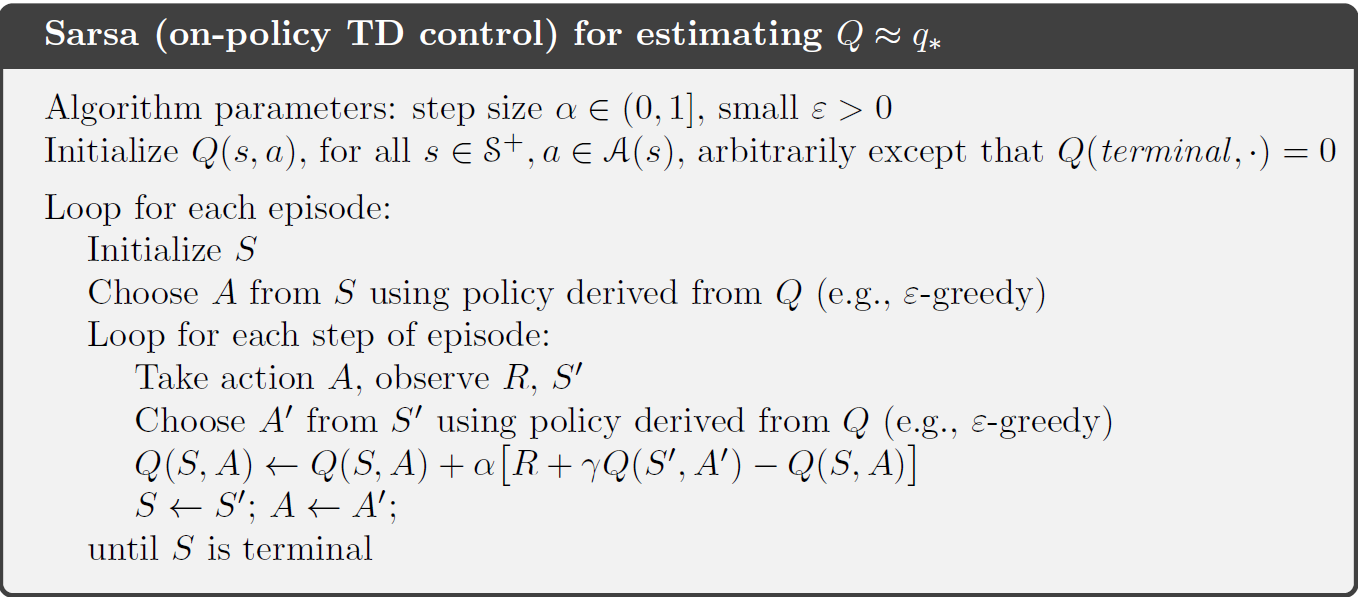

# Defining the Agent

In [193]:
class SARSA_Agent:
  def __init__(self, env, epsilon = 1.0, lr = 0.1, gamma = 0.9):
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space
        self.Q_table = np.zeros((self.env.n, self.env.n, env.action_space.n))
        self.epsilon = epsilon
        self.lr = lr
        self.gamma = gamma

  # ε-greedy policy
  def policy(self, observation):
    if np.random.random() < self.epsilon:
      # Exploration Step:
      return np.random.choice(self.action_space.n)
    else:
      # choose from q-table
      # Exploitation Step:
      observation = observation.astype(int)
      return np.argmax(self.Q_table[observation[0]][observation[1]])
      
  def set_epsilon(self, epsilon):
    self.epsilon = epsilon

  def step(self, observation):
    return self.policy(observation)

  def update(self, curr_state, curr_action, reward, next_state, next_action):
      curr_state = curr_state.astype(int)
      next_state = next_state.astype(int)
      # updating the Q-Table as per SARSA estimation
      self.Q_table[curr_state[0]][curr_state[1]][curr_action] += self.lr * (reward + self.gamma * self.Q_table[next_state[0]][next_state[1]][next_action] - self.Q_table[curr_state[0]][curr_state[1]][curr_action])


# Markov Decision Process

In [194]:
def MDP(episodes, n = 5, isStochastic = False, randomStart = False, epsilon = 1.0, lr = 0.1, gamma = 0.9):
  # Setting up environment
  env = GridEnvironment(5, is_stochastic = isStochastic, random_start = randomStart)
  # Initializing agent
  agent = SARSA_Agent(env, epsilon = epsilon, lr = lr, gamma = gamma)
  delta_epsilon = agent.epsilon / episodes

  total_rewards = []
  epsilons = [agent.epsilon]
  steps = 0

  for episode in range(episodes):
    obs = env.reset()
    done = False
    if episode > 0:
      epsilon = agent.epsilon - (5 * agent.epsilon * delta_epsilon)
      epsilons.append(epsilon)
      agent.set_epsilon(epsilon)
    
    curr_reward = 0
    action = agent.step(obs)

    while not done:
      curr_state = obs.copy()
      obs, reward, done, info = env.step(action)
      curr_reward += reward
      next_state = obs.copy()
      next_action = agent.step(next_state)
      agent.update(curr_state, action, reward, next_state, next_action)
      action = next_action
      steps += 1
    total_rewards.append(curr_reward)
    
  print(f'On Average {steps / episodes} steps per episode')
  return env, agent, total_rewards, epsilons

In [195]:
def plotGraphs(epsilons, total_rewards):
  # Plotting ε vs Episodes
  plt.figure(1)
  plt.xlabel('Episodes')
  plt.ylabel('$\epsilon$')
  plt.plot(epsilons)

  # Plotting Total rewards received vs Episodes
  plt.figure(2)
  step = 10
  plt.xlabel('Episodes')
  plt.ylabel('Total Reward (SMA 10)')
  plt.plot([np.mean(total_rewards[i : i + step]) for i in range(len(total_rewards))])

In [196]:
def test(env, agent):
  # While testing, we'll exploit the Q-table formed during training and take the action with max value.
  obs = env.reset()
  done = False
  agent.epsilon = 0
  env.render()

  while not done:
      action = agent.step(obs)
      obs, reward, done, info = env.step(action)
      env.render()

# Deterministic Environment

In [197]:
env, agent, total_rewards, epsilons = MDP(episodes = 3000)
agent.Q_table

On Average 10.235333333333333 steps per episode


array([[[ 4.77837631e+00,  3.81834698e+00,  2.63499852e+00,
          3.66040897e+00],
        [-9.69272378e-02,  1.92127563e-01, -1.45373513e-01,
          3.61183238e+00],
        [-1.20171243e+00, -1.79540879e-01,  6.93774898e-02,
         -1.17317089e-01],
        [ 1.54006618e-02,  1.73015993e-02,  4.74903374e-01,
         -5.39209405e-02],
        [ 1.46799184e+00, -8.42279293e-03,  2.12907448e-01,
          1.58357685e-02]],

       [[ 5.31209086e+00,  3.58635338e+00,  3.13129095e+00,
          4.44062073e+00],
        [ 2.25579055e-01,  2.96673667e-02, -5.00662919e-01,
          4.30536887e+00],
        [-9.11370619e+00, -1.92508392e-01,  3.34117286e-01,
         -2.60481155e-01],
        [-3.79868704e-01, -1.78115549e-02,  1.54869564e+00,
         -1.44472476e+00],
        [ 3.41420834e+00,  1.64012828e-01,  4.95294347e-01,
         -4.03085711e-01]],

       [[ 5.90388937e+00,  4.03603407e+00,  4.10224034e+00,
          4.58853702e+00],
        [ 5.98439310e+00,  4.08248281e-

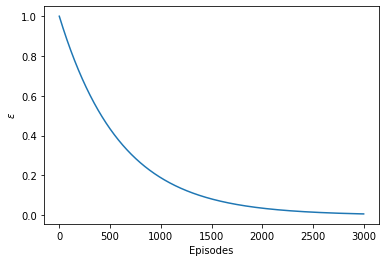

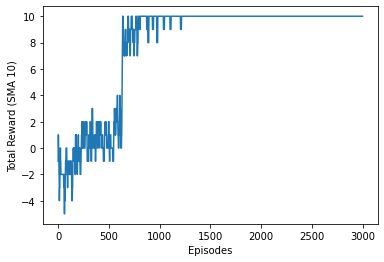

In [198]:
plotGraphs(epsilons, total_rewards)

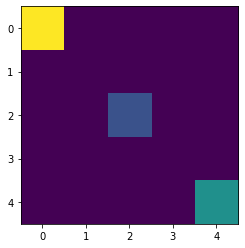

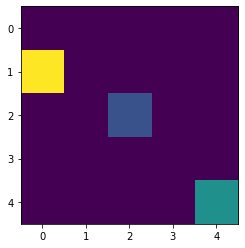

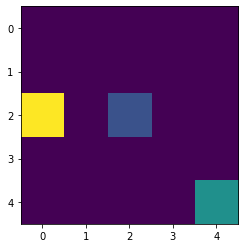

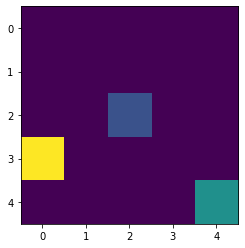

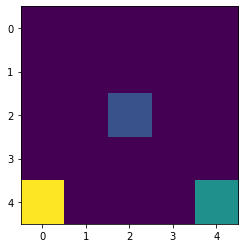

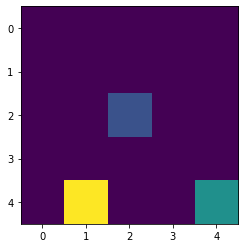

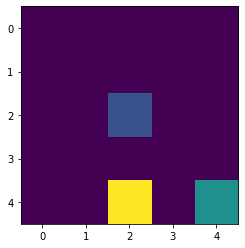

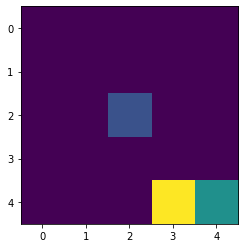

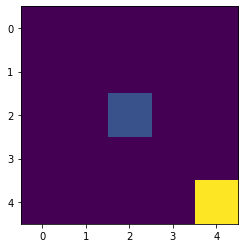

In [199]:
test(env, agent)

# Stochastic Environment

In [200]:
env, agent, total_rewards, epsilons = MDP(episodes = 30000, isStochastic = True)
agent.Q_table

On Average 13.261066666666666 steps per episode


array([[[ 2.30882796,  2.3199221 ,  2.60814855,  2.30006225],
        [ 2.17923965,  2.38622343,  2.97565974,  2.42195702],
        [ 2.38810639,  2.86278363,  3.53190458,  2.3179117 ],
        [ 3.80965711,  3.65798504,  4.61369502,  3.42496237],
        [ 5.58589447,  4.42700682,  4.29753296,  4.24405184]],

       [[ 2.82200258,  2.24683541,  2.21006154,  2.37423465],
        [ 1.55460235,  1.58486393,  1.65488451,  2.31996954],
        [-5.38276167, -0.3189937 ,  3.25305848, -1.02630168],
        [ 3.3053325 ,  3.60626658,  5.08964422,  2.59277615],
        [ 6.32796434,  4.67319327,  5.06310441,  4.73600159]],

       [[ 3.6437505 ,  2.42821643,  1.87798339,  2.49098592],
        [-2.09917957, -1.67547941, -9.12671197,  0.75612743],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 6.36448966,  1.11479377,  0.61106739, -7.66886448],
        [ 7.67799485,  5.62368319,  5.74262854,  5.14347482]],

       [[ 4.63463373,  3.49705174,  3.84448911,  3.75829731],
  

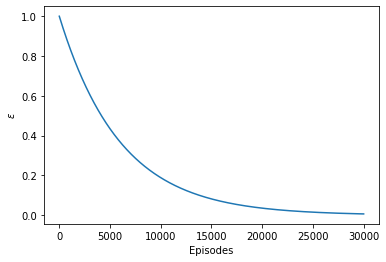

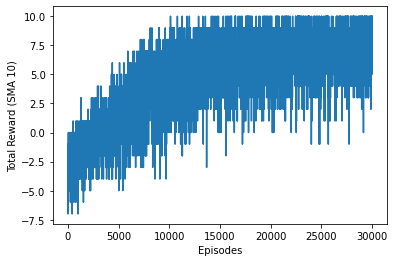

In [201]:
plotGraphs(epsilons, total_rewards)

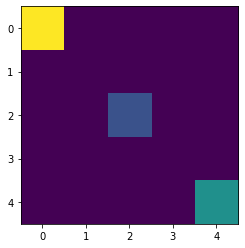

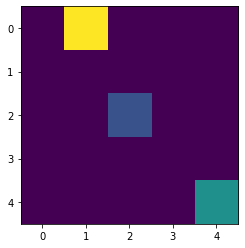

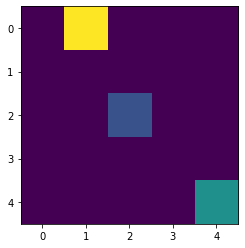

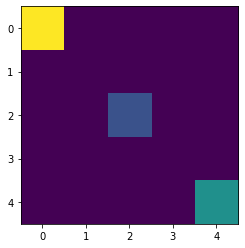

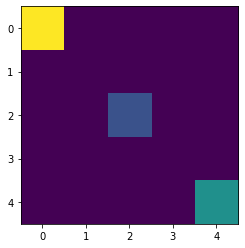

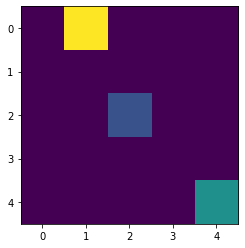

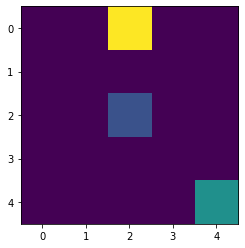

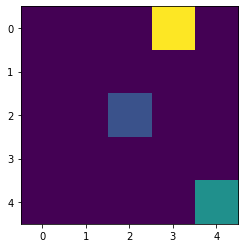

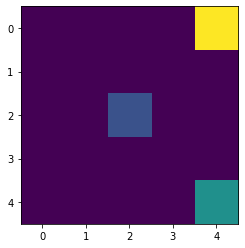

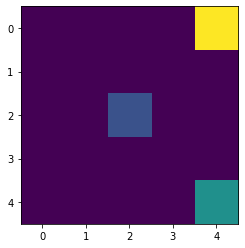

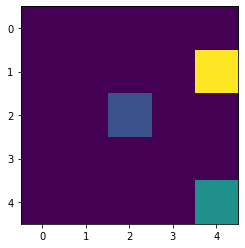

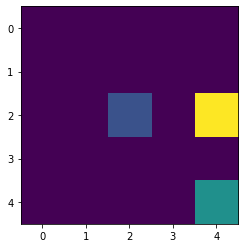

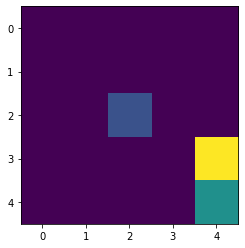

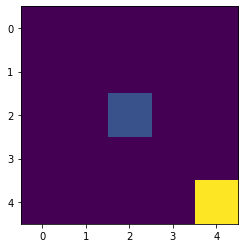

In [204]:
test(env, agent)

# Agent Starts from Random position

In [205]:
env, agent, total_rewards, epsilons = MDP(episodes = 3000, randomStart = True)
agent.Q_table

On Average 5.620333333333333 steps per episode


array([[[ 1.76428095e+00,  2.17540411e+00,  2.60457091e+01,
          2.72235581e+00],
        [ 6.41563706e+00,  3.20476807e+00,  3.04672738e+01,
          1.57098749e+00],
        [ 5.20536368e+00,  1.10236259e+01,  3.47109044e+01,
          7.65762714e+00],
        [ 8.72209422e+00,  6.12442164e+00,  3.91022336e+01,
          7.67024448e+00],
        [ 4.40290741e+01,  1.08444684e+01,  1.24468538e+01,
          9.57706877e+00]],

       [[ 3.34552003e+00,  2.07369970e+01,  1.77834380e-01,
          1.96204298e-01],
        [ 5.17818644e-02,  2.49261756e+01,  1.72296979e-01,
          1.31007335e+00],
        [-8.78398530e+00,  2.88255379e+01,  1.11542870e+00,
          2.34711480e-01],
        [ 4.92005415e+00,  8.87181033e+00,  4.05035655e+01,
          1.15346231e-01],
        [ 4.95325974e+01,  1.53443943e+01,  1.78061116e+01,
          1.75504019e+01]],

       [[ 2.82825694e+01,  2.12905356e-01, -8.75879321e-01,
         -4.62560104e-02],
        [ 3.32654966e+01,  8.84154334e-

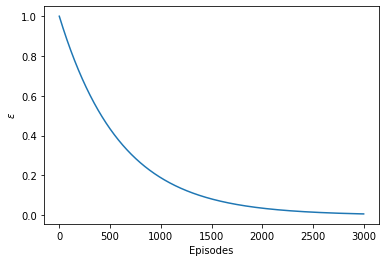

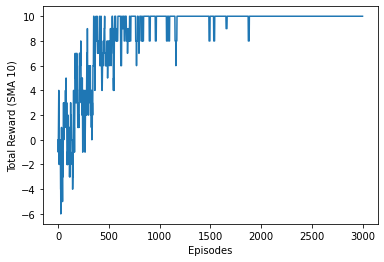

In [206]:
plotGraphs(epsilons, total_rewards)

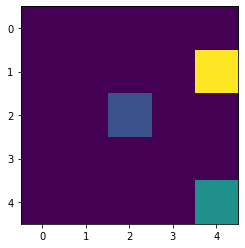

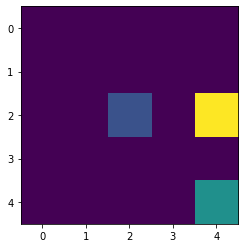

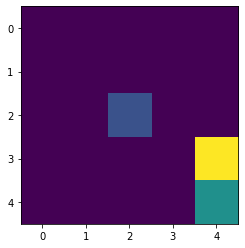

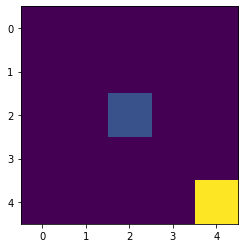

In [207]:
test(env, agent)

# Agent Starts from Random Position in Stochastic Environment

In [208]:
env, agent, total_rewards, epsilons = MDP(episodes = 30000, isStochastic = True, randomStart = True)
agent.Q_table

On Average 7.511466666666666 steps per episode


array([[[22.36628082, 14.05173406, 17.05987466, 12.83996162],
        [18.00553214, 16.52169867, 26.02667969, 15.79696748],
        [22.57142265, 22.90731187, 30.21679035, 22.29099219],
        [34.84979062, 27.88469688, 29.30367811, 24.02746207],
        [38.42908887, 32.55286962, 31.18469032, 28.37069882]],

       [[24.78412013, 17.78134641, 20.70908841, 18.64625087],
        [28.28746231, 17.6671552 , 22.07455897, 17.11915769],
        [20.11638197, 20.61969257, 31.69020388, 21.03319907],
        [41.14850785, 29.74132251, 33.33863836, 28.34486007],
        [46.83773624, 33.31343785, 38.35720658, 34.42555768]],

       [[29.10838215, 20.89963852, 23.56446515, 22.55234664],
        [33.98152678, 23.177474  , 20.59477289, 23.00788323],
        [38.28328105, 19.72359303, 22.84500075, 18.82296794],
        [45.4358595 , 30.82598122, 37.63343742, 26.53702588],
        [56.95200976, 40.05392431, 44.47899138, 40.86239371]],

       [[29.1625286 , 26.14097949, 35.16934529, 27.07926444],
  

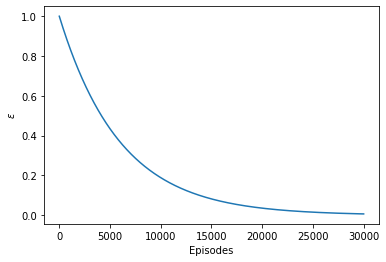

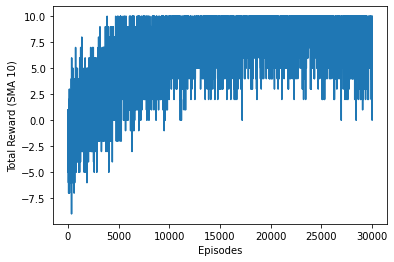

In [209]:
plotGraphs(epsilons, total_rewards)

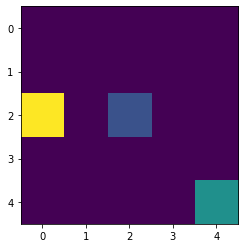

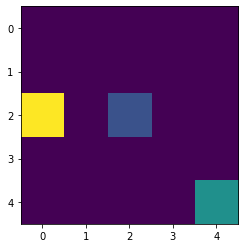

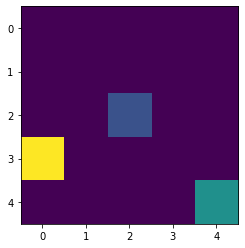

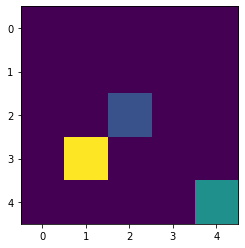

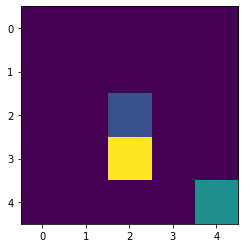

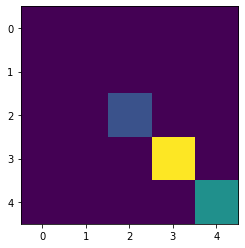

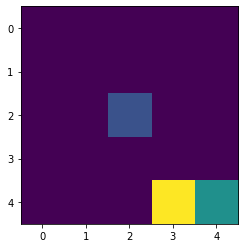

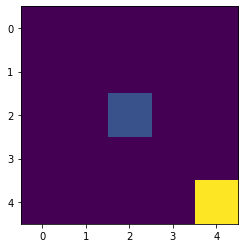

In [210]:
test(env, agent)